Custom ResNet18 Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.tensorboard import SummaryWriter

Set data directory, wanted batch size and the number of epochs for the training process

In [ ]:
dataDir = "Dataset"
batchSize = 16
numEpochs = 10
writer = SummaryWriter(log_dir="runs/resnet18_screw_classifier")

Try to utilizes CUDA-cores for training, otherwise the CPU will be used. The path for the model is also determined

In [ ]:
modelPath = "resnet18_screw_classifier.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The imagetransformation is defined and the images will be resized to 224x224, as ResNet18 was trained on that size.

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(dataDir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(dataDir, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['Machine', 'Philips', 'Plaster', 'Torx']


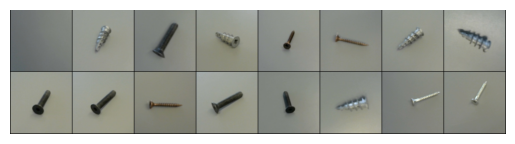

In [26]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images from your custom dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images as a grid
imshow(torchvision.utils.make_grid(images))

The model is loaded/downloaded

In [28]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

With the model loaded, the training of the ResNet18 model using the images taken can be initialized

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----- TRAINING LOOP -----
print("Training...")
for epoch in range(numEpochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            writer.add_scalar("Loss/train_batch", loss.item(), epoch * len(train_loader) + i)

    avg_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/train", avg_loss, epoch)

Training...
Epoch 1/5, Loss: 0.2177
Epoch 2/5, Loss: 0.2617
Epoch 3/5, Loss: 0.1412
Epoch 4/5, Loss: 0.1308
Epoch 5/5, Loss: 0.1911


When the model i trained, the validation images will be used to find the accuracy of the ResNet model

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")
writer.add_scalar("Accuracy/val", val_accuracy, epoch)

Validation Accuracy: 47.65%


Save the model

In [ ]:
writer.close()
torch.save(model.state_dict(), modelPath)
print(f"Model saved to {modelPath}")

Model saved to resnet18_custom.pth
